In [1]:
# Pretty plotting config
%run plot_conf.py

/Users/alexeys-laptop/.local/lib/python3.6/site-packages/matplotlib/__init__.py:915: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


In [2]:
# Set style (need to be in a new cell)
plt_style()

/Users/alexeys-laptop/.local/lib/python3.6/site-packages/matplotlib/__init__.py:915: MatplotlibDeprecationWarning: nbagg.transparent is deprecated and ignored. Use figure.facecolor instead.
  mplDeprecation)


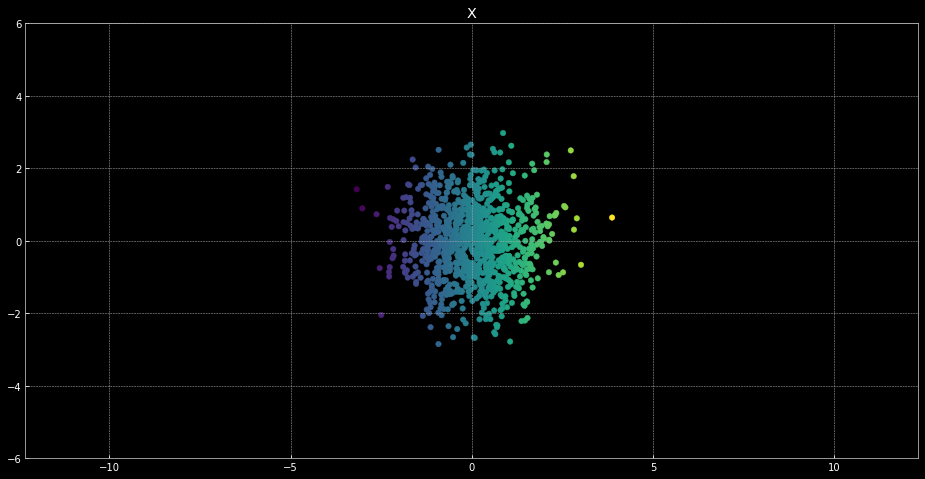

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt


# utility function
def show_scatterplot(X, norm=True, title=''):
    X = X.numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=p_size)
    if norm:
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
    plt.grid(True)
    plt.title(title)


# generate some points in 2-D space
n_points = 1000
p_size = 30
X = torch.randn(n_points, 2) 
colors = X[:, 0].numpy() 

show_scatterplot(X, norm=True, title='X')

# Visualizing Linear Transformations

* Generate a random matrix $W$

$
\begin{equation}
    W = U
  \left[ {\begin{array}{cc}
   s_1 & 0 \\
   0 & s_2 \\
  \end{array} } \right]
  V^\top
\end{equation}
$
* Compute $y = Wx$
* Larger singular values stretch the points
* Smaller singular values push them together
* $U, V$ rotate/reflect

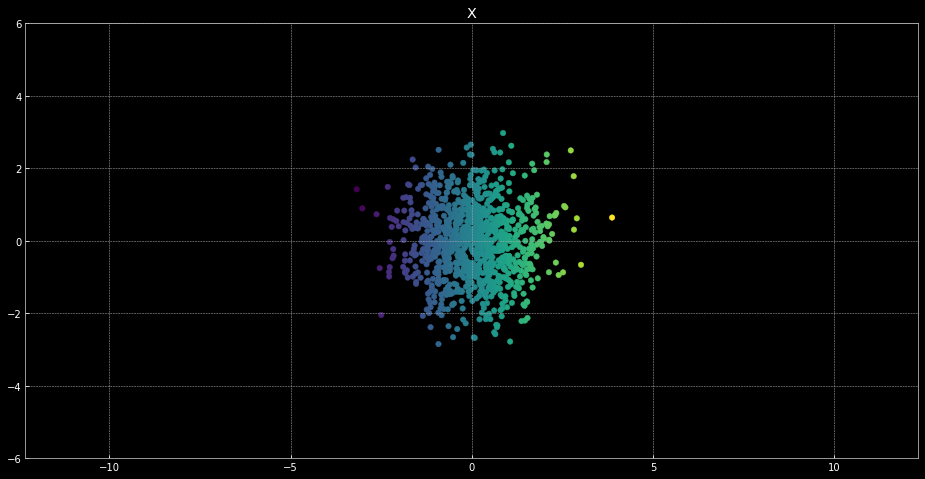

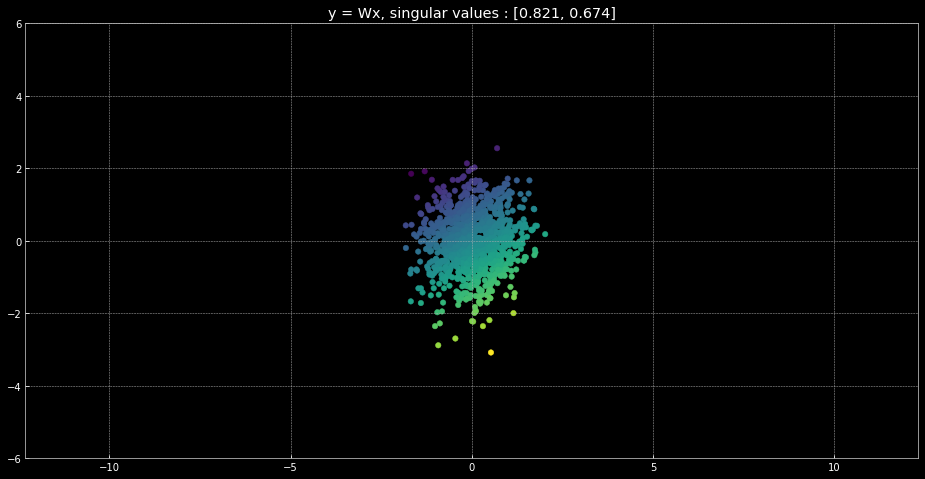

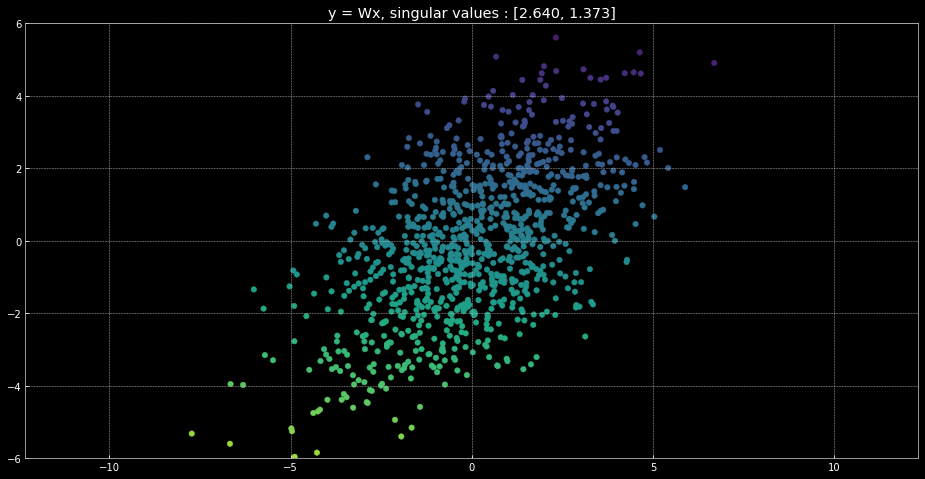

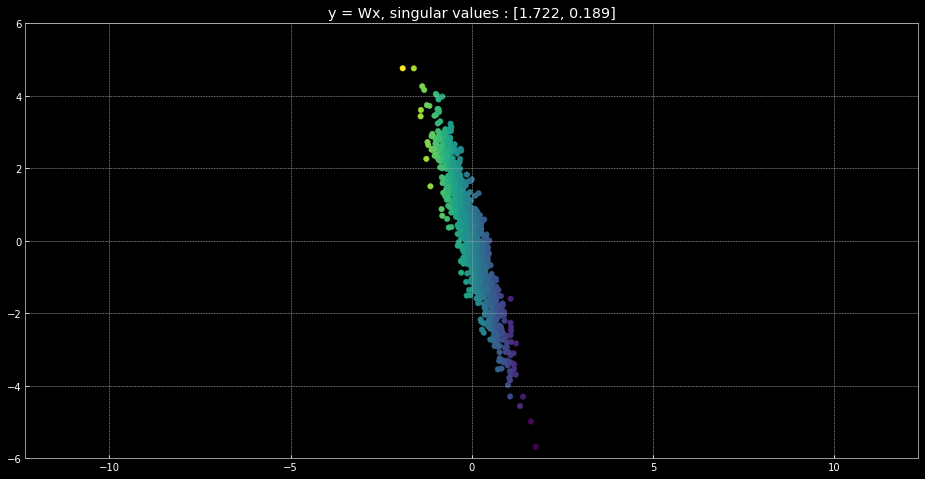

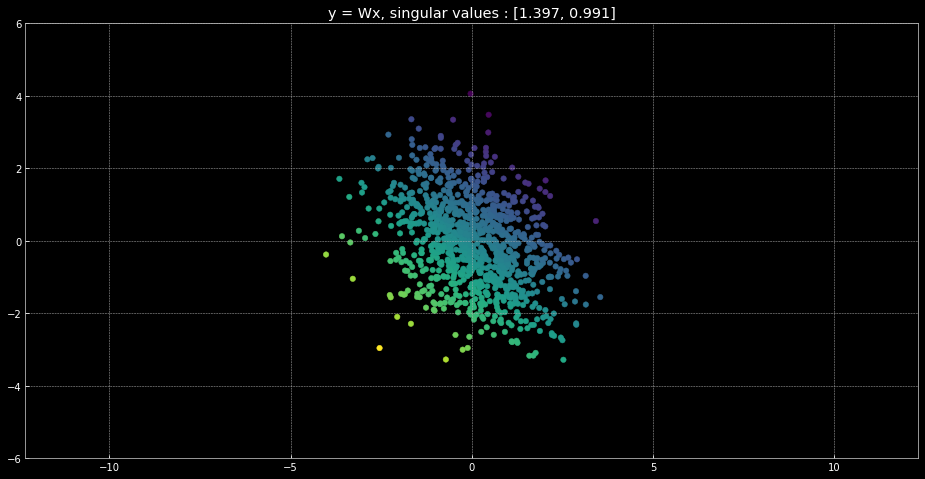

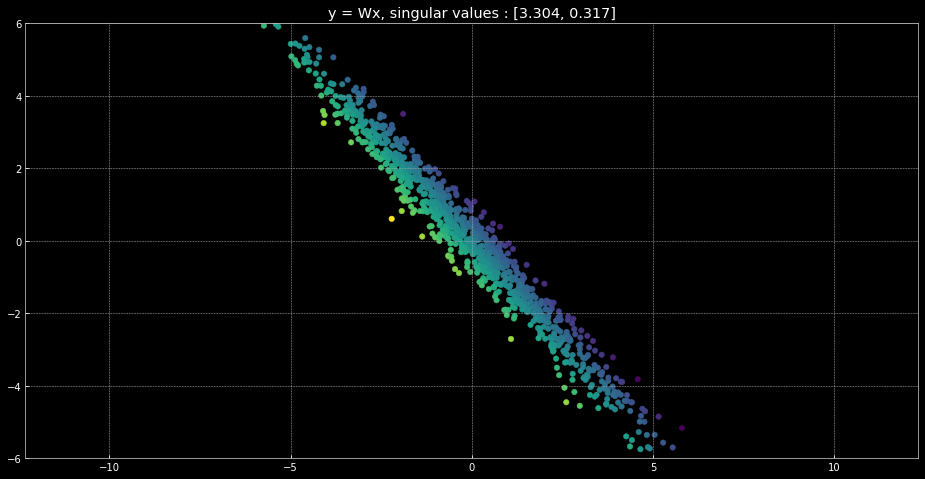

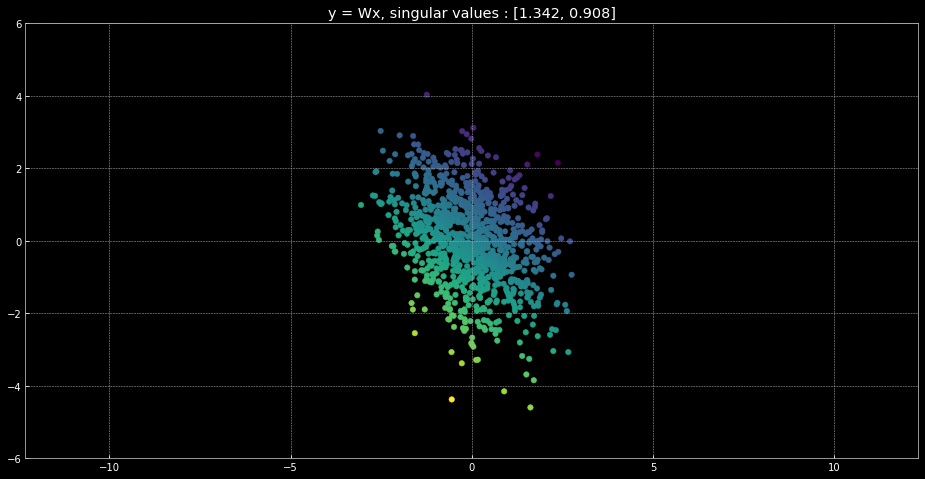

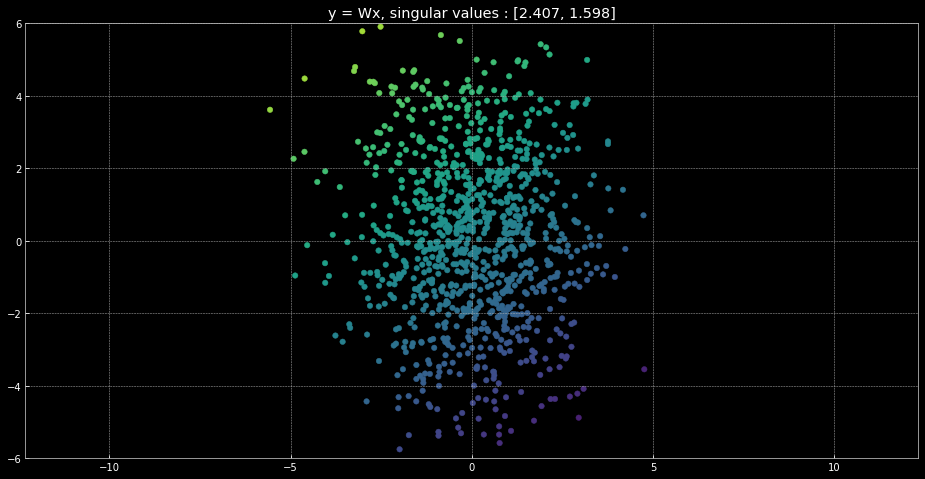

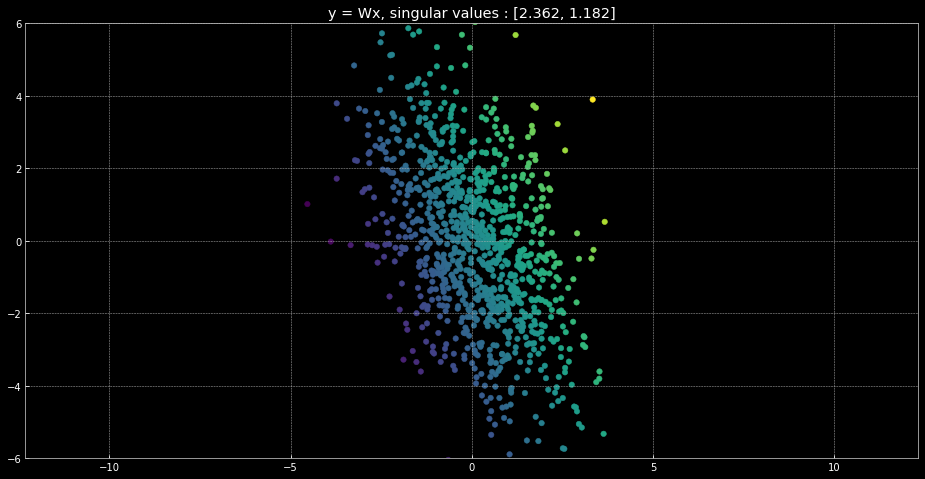

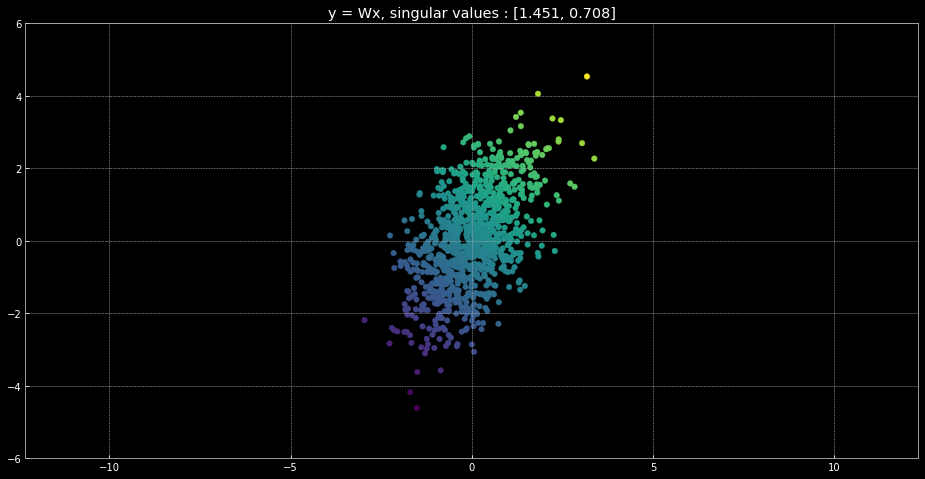

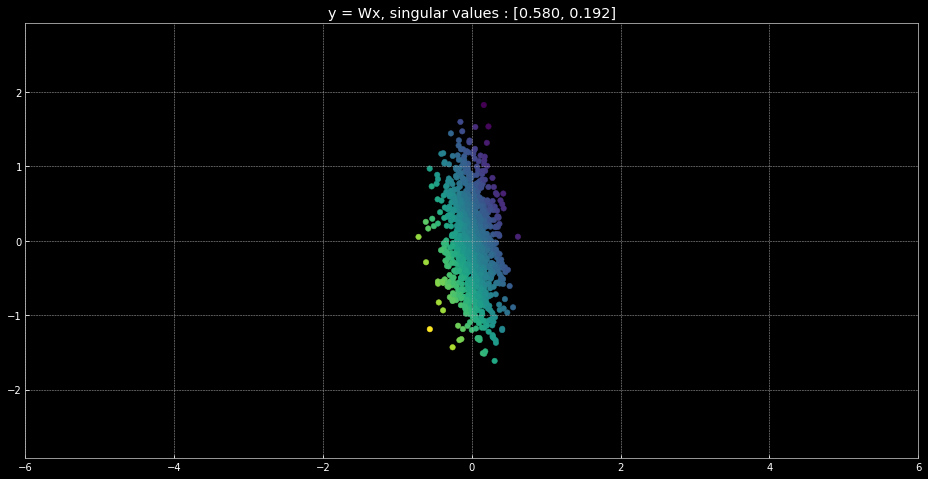

In [4]:
show_scatterplot(X, norm=True, title='X')

for i in range(10):
    # create a random matrix
    W = torch.randn(2, 2)
    # transform points
    Y = torch.mm(X, W)
    # compute singular values
    U,S,V = torch.svd(W)
    # plot
    show_scatterplot(Y, norm=True, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))

# Linear transformation with PyTorch

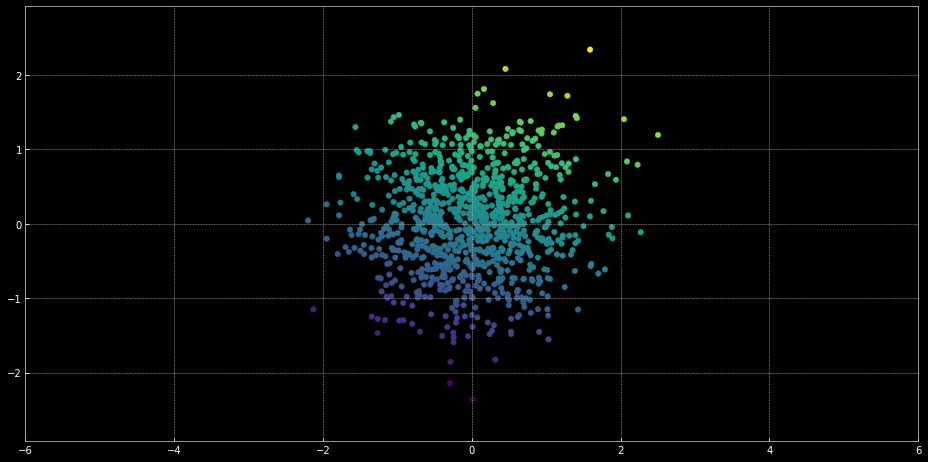

In [5]:
model = nn.Sequential(
        nn.Linear(2, 2, bias=False)
)
Y = model(Variable(X)).data
show_scatterplot(Y)

# Non-linear Transform: Map Points to a Square

* Linear transforms can rotate, reflect, stretch and compress, but cannot curve
* We need non-linearities for this
* Can (approximately) map points to a square by first stretching out by a factor $s$, then squashing with a tanh function

$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s & 0 \\
   0 & s \\
  \end{array} } \right]  
  x
  \right)
$

Text(0.5,1,'tanh() non linearity')

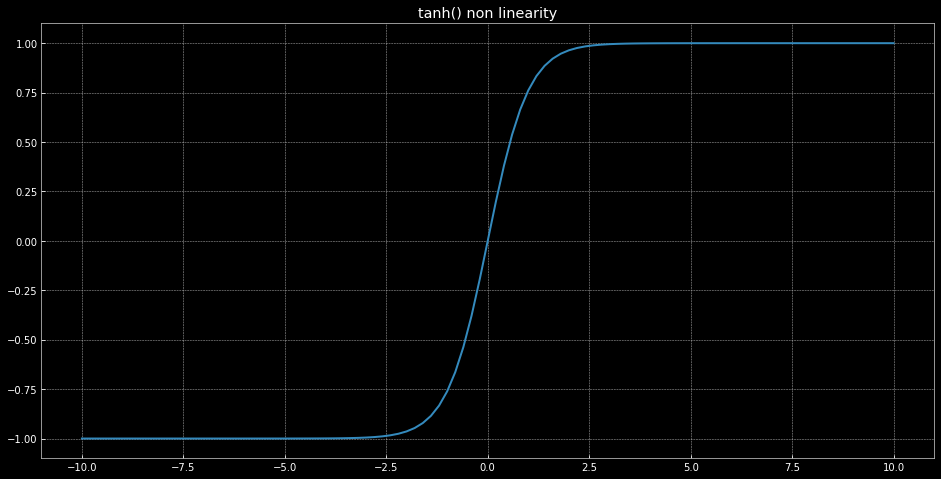

In [6]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)
plt.plot(z.numpy(), s.numpy())
plt.title('tanh() non linearity')

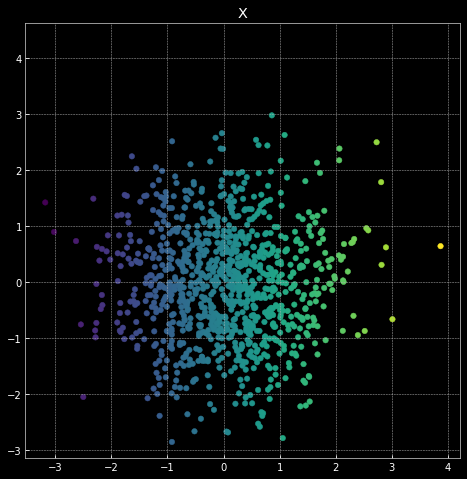

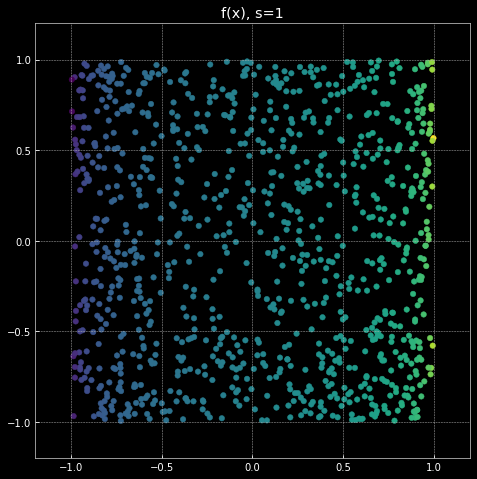

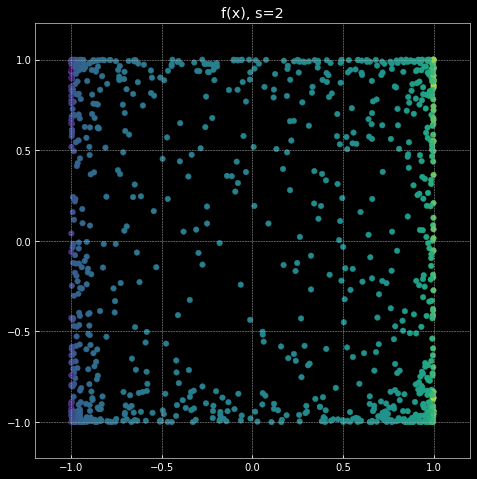

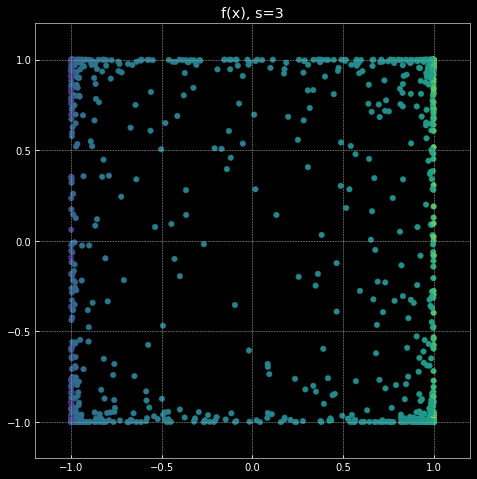

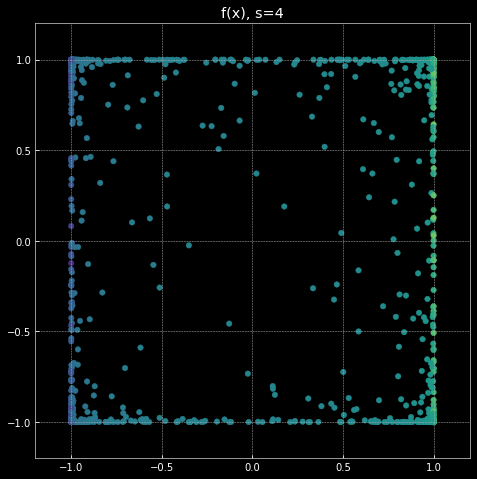

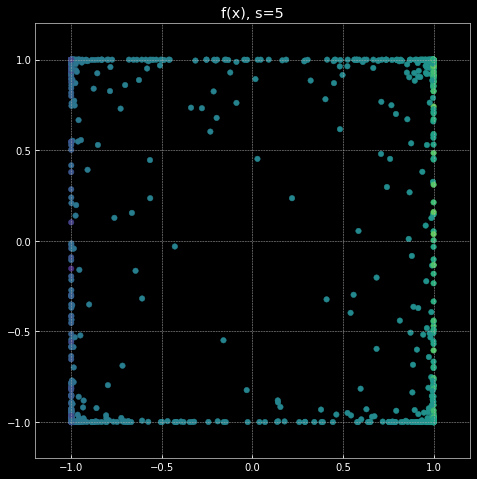

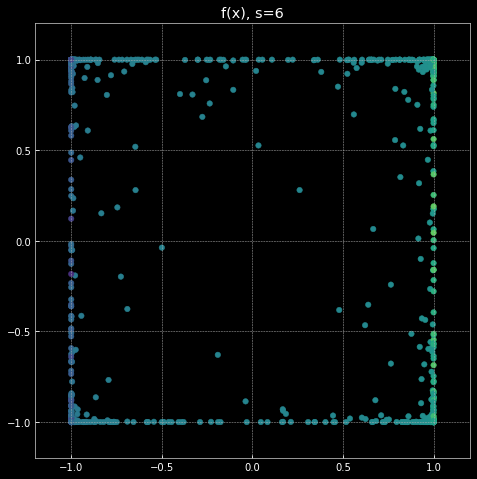

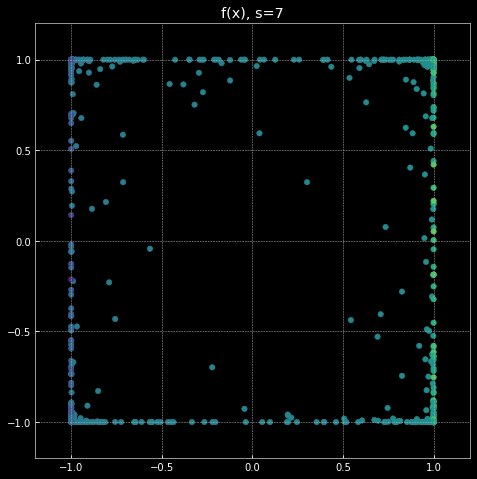

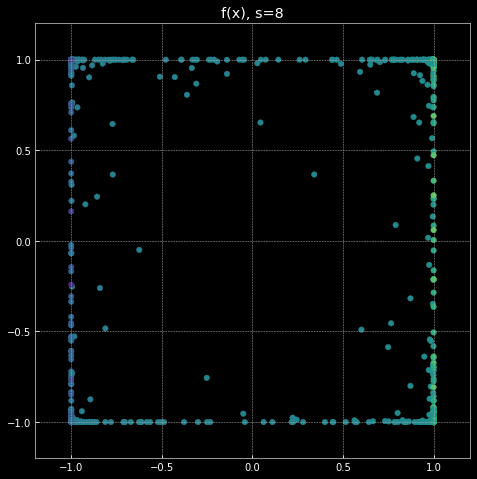

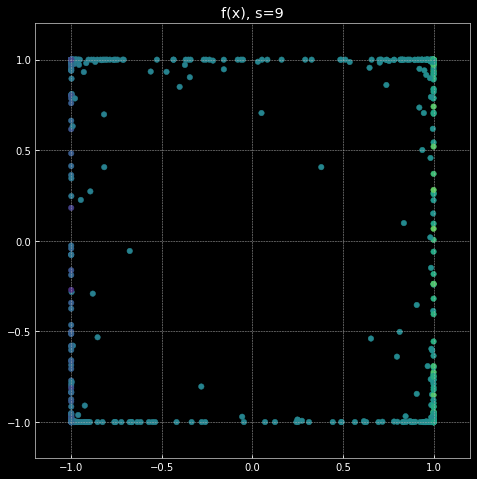

In [7]:
show_scatterplot(X, title='X')
plt.axis('square')

model = nn.Sequential(
        nn.Linear(2, 2, bias=False),
        nn.Tanh()
    )

for s in range(1, 10):
    W = s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(Variable(X)).data
    show_scatterplot(Y, False, title='f(x), s={}'.format(s))
    plt.axis('square')
    plt.axis([-1.2, 1.2, -1.2, 1.2])

# Visualize Functions Represented by Random Neural Networks

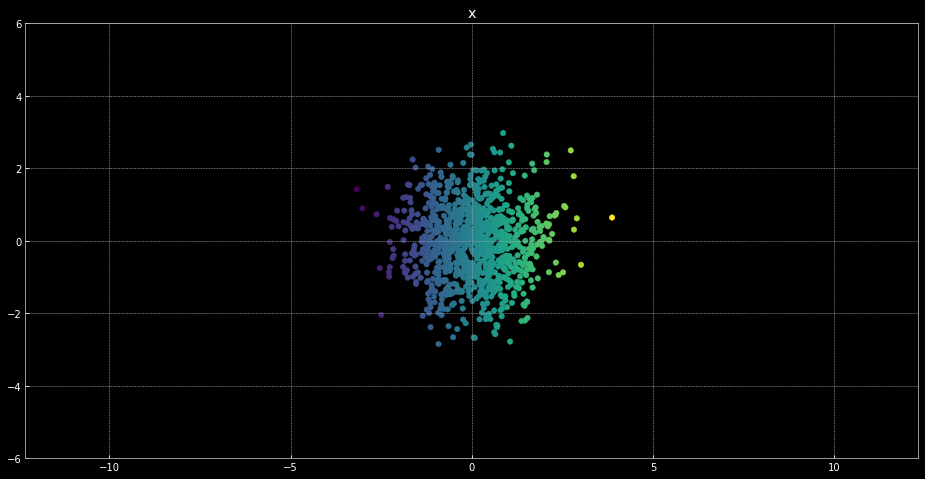

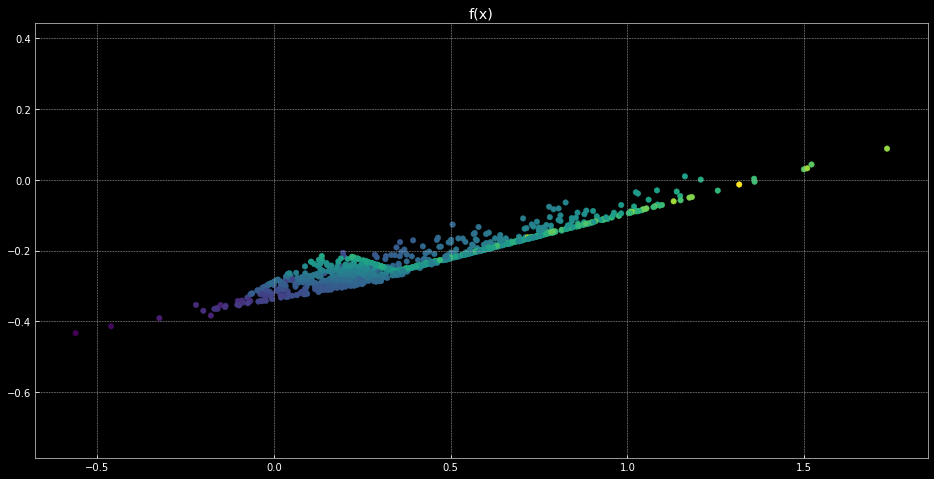

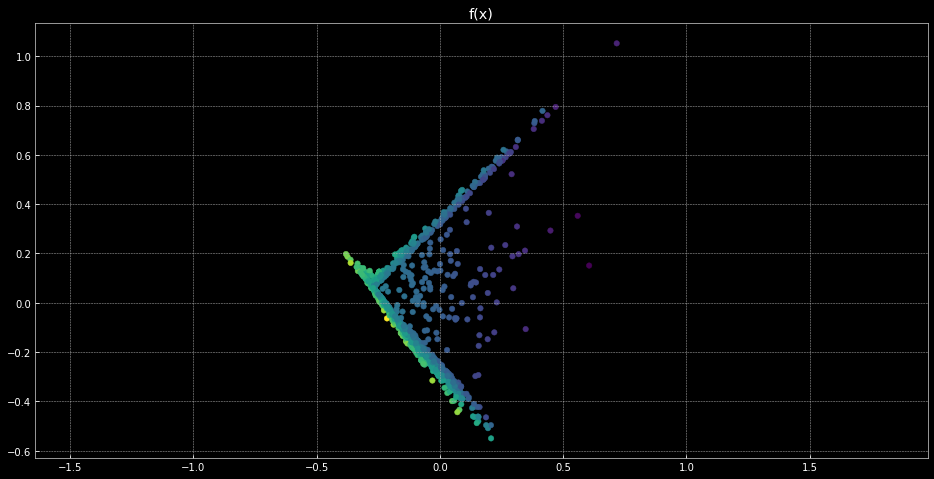

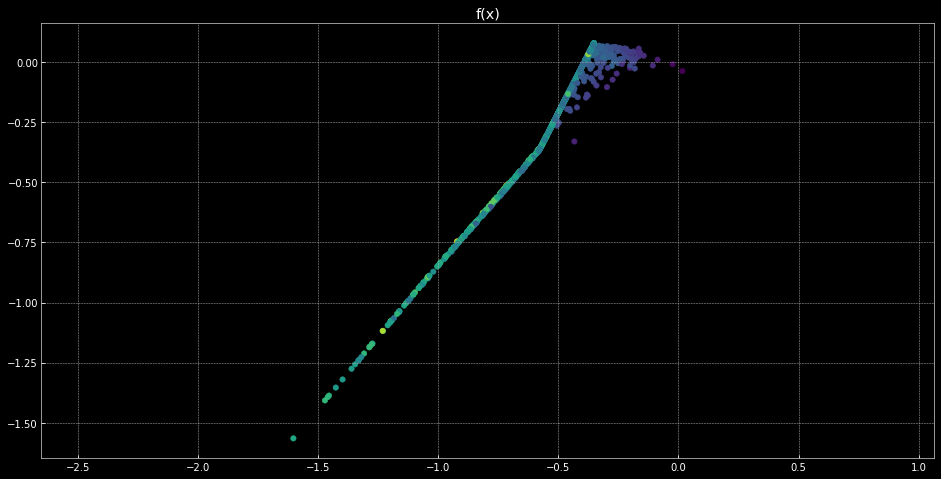

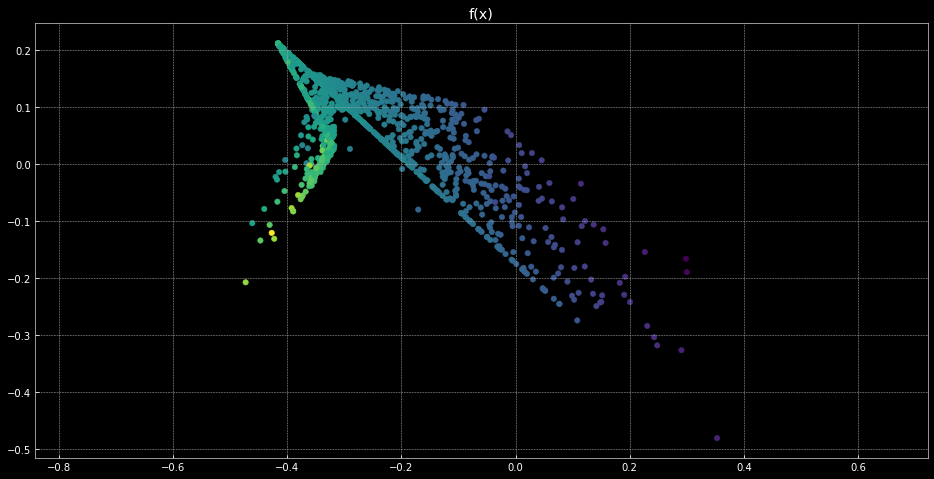

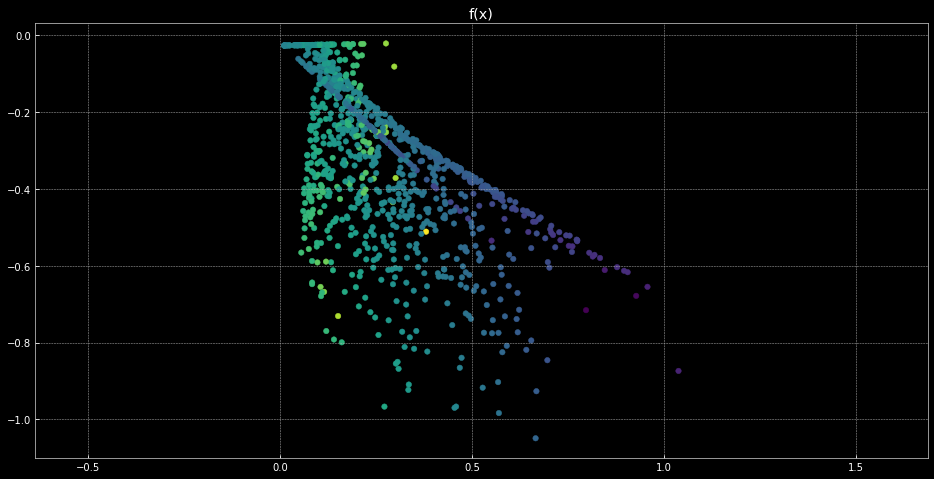

In [8]:
show_scatterplot(X, title='x')
n_hidden = 5

for i in range(5):
    # create 1-layer neural networks with random weights
    model_1layer = nn.Sequential(
            nn.Linear(2, n_hidden, bias=True), 
            nn.ReLU(), 
            nn.Linear(n_hidden, 2, bias=True)
        )
    Y = model_1layer(Variable(X)).data
    show_scatterplot(Y, False, title='f(x)')

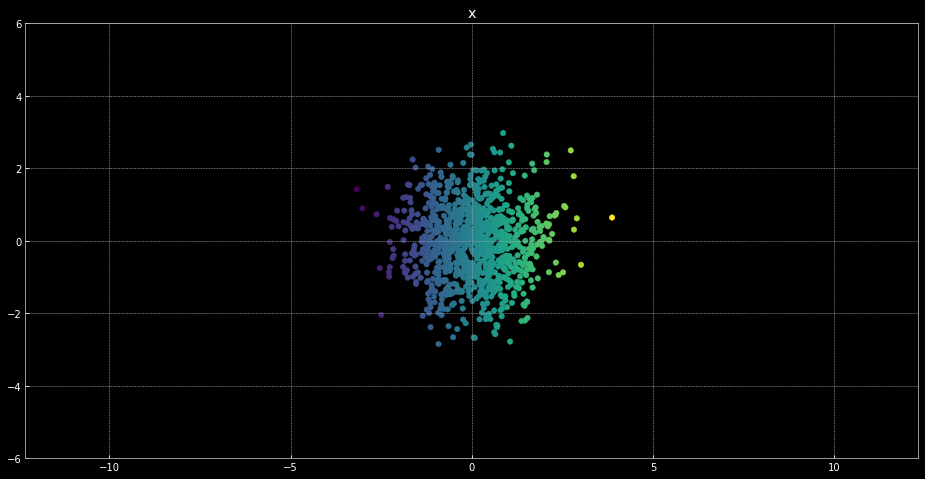

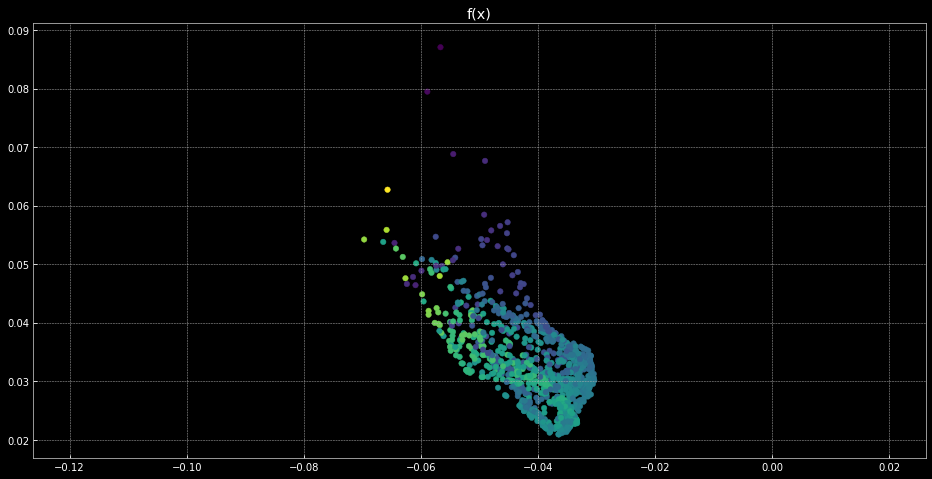

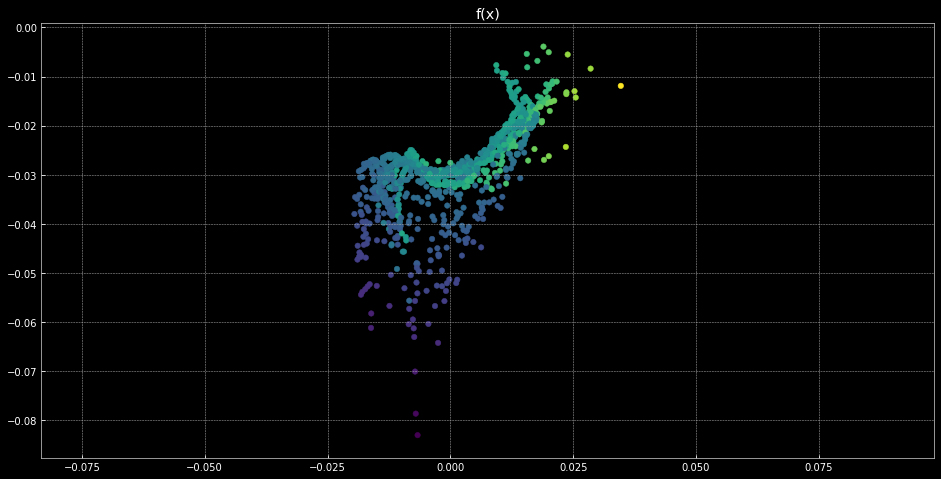

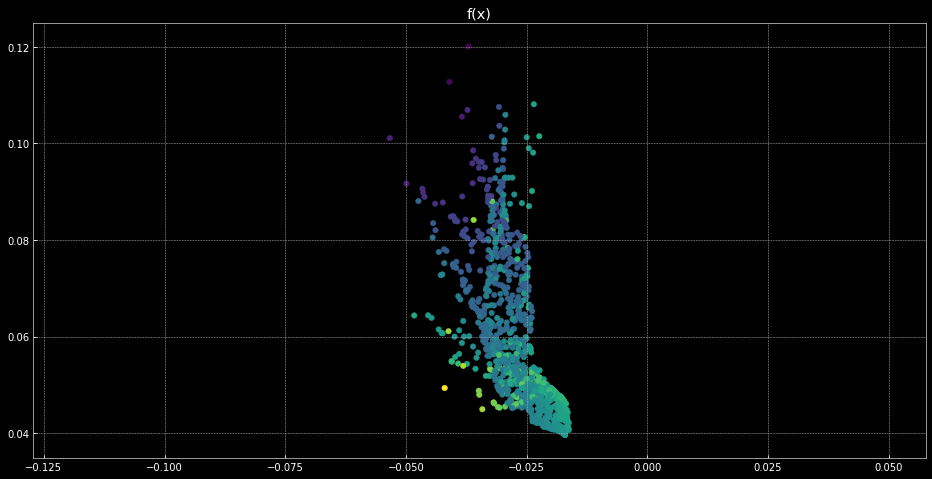

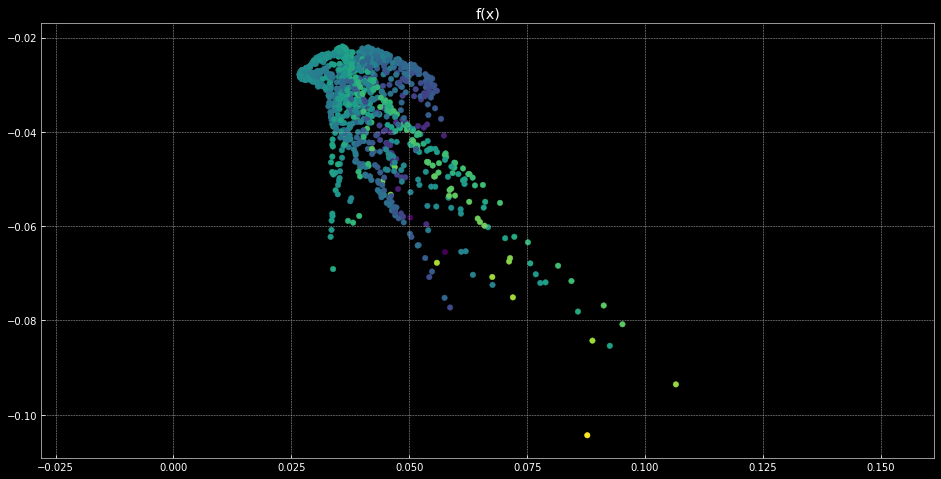

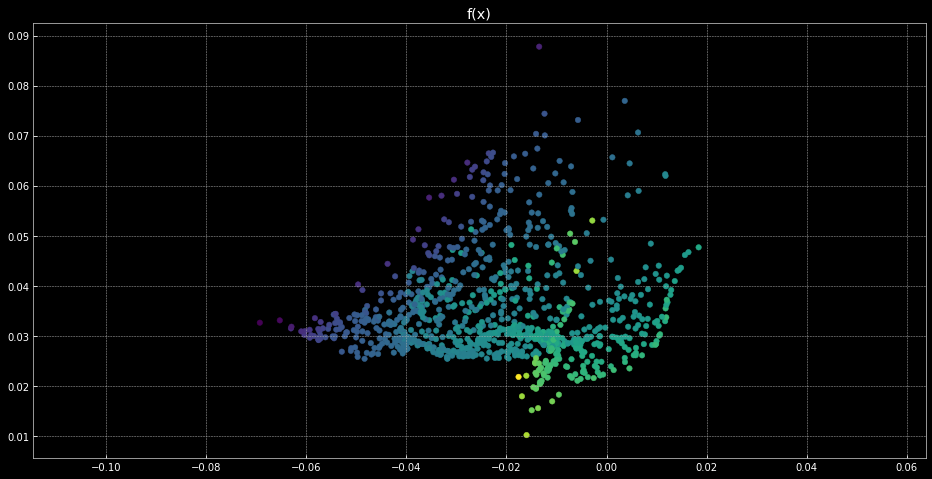

In [9]:
# deeper network with random weights
show_scatterplot(X, title='x')
n_hidden = 1000

for i in range(5):
    model_2layer = nn.Sequential(
        nn.Linear(2, n_hidden, bias=True), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden, bias=True), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden, bias=True), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden, bias=True), 
        nn.ReLU(), 
        nn.Linear(n_hidden, 2, bias=True)
    )
    Y = model_2layer(Variable(X)).data
    show_scatterplot(Y, False, title='f(x)')


